In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
from scipy.optimize import minimize
from scipy.interpolate import griddata
import pandas as pd

#### Christian Buhl Sørensen
cbs@nano.aau.dk, 15/08 - 2019

# Aim of notebook
This notebook shows the fit of the 3D scan data to a meterologically flat plane. The plane is a class B granite surface plate manufactured by C.E. Johansson. It is old, so likely not within spec, which is written to be 0.011 (mm, i presume - not stated on label)

In [2]:
class pointCloud:
    def __init__(self, xx, yy, zz):
        self.points = np.array([xx.flatten(),yy.flatten(),zz.flatten()])
    

    
    def plot(self, fig = None, ax=None):
        def set_aspect_equal_3d(ax):
            """Fix equal aspect bug for 3D plots.
                Courtesy of user dalum,
                https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to
            """

            xlim = ax.get_xlim3d()
            ylim = ax.get_ylim3d()
            zlim = ax.get_zlim3d()

            from numpy import mean
            xmean = mean(xlim)
            ymean = mean(ylim)
            zmean = mean(zlim)

            plot_radius = max([abs(lim - mean_)
                               for lims, mean_ in ((xlim, xmean),
                                                   (ylim, ymean),
                                                   (zlim, zmean))
                               for lim in lims])

            ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
            ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
            ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])
        
        if not fig:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.points[0], self.points[1], self.points[2], alpha = 0.8)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        #ax.set_aspect('equal')
        set_aspect_equal_3d(ax)
        
        return fig, ax
        
    def rotate(self, axis, angleDegrees):
        '''
        Takes two arguments; the axis of rotation and the angle of rotation. The angle is in radians.
        
        Please remember that it rotates around the coordinate point (0,0,0). It's a bit tricky.
        '''
        r = None
        
        angle = angleDegrees/180*np.pi
        
        if axis == "X": r = Rotation.from_rotvec(angle * np.array([1, 0, 0]))
        if axis == "Y": r = Rotation.from_rotvec(angle * np.array([0, 1, 0]))
        if axis == "Z": r = Rotation.from_rotvec(angle * np.array([0, 0, 1]))
        
        if r:
            self.points = r.apply(self.points.T).T
        
        return self
    
    def rotateEuler(self, alpha, beta, gamma):
        r = Rotation.from_euler('xyz', [alpha, beta, gamma], degrees = True)
        self.points = r.apply(self.points.T).T
        
        return self
        
    def displace(self, axis, distance):
        if axis == "X":   self.points[0] += distance
        elif axis == "Y": self.points[1] += distance
        elif axis == "Z": self.points[2] += distance
        else:             pass
        
        return self
    
    def addNoise(self, axis, std):
        if axis == "X":   self.points[0] += np.random.randn(len(self.points[0]))*std
        elif axis == "Y": self.points[1] += np.random.randn(len(self.points[1]))*std
        elif axis == "Z": self.points[2] += np.random.randn(len(self.points[2]))*std
        else:             pass
        
        return self
    
    def copy(self):
        return pointCloud(self.points[0].copy(), self.points[1].copy(), self.points[2].copy())
    
    def copyCropped(self, N):
        return pointCloud(self.points[0][::N].copy(),
                          self.points[1][::N].copy(),
                          self.points[2][::N].copy())

In [3]:
df = pd.read_csv('/Users/cbs/Documents/3D_mirrors/Scanninger/Maskin_plan_clean.xyz', header = None, names=['x','y','z','NA0','NA1','NA2'], delim_whitespace=True)

In [4]:
data = pointCloud(df.x.to_numpy(), df.y.to_numpy(), df.z.to_numpy())
del df

In [5]:
foo = data.copy()

### Timing rotations and displacement operations on the large dataset

In [6]:
%timeit foo.rotate('Y', 45.3)

181 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%timeit foo.rotateEuler(4.5, 234.5, 43.4)

187 ms ± 6.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit foo.displace('X', 34.5)

1.92 ms ± 48.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This turns out to be surprisingly fast! 

# Aligning to flat plane
The objective function is just to do one euler rotation, and one displacement along Z, to minimize the sum Z. That should align to the z-plane in 0.

In [9]:
def objectiveEuler(params, *args):
    alpha, beta, gamma, dispZ = params
    sample = args[0]
    plotBool = args[1]
    printRA = args[2]
    returnData = args[3]
    sampleDisplaced = pointCloud(sample.points[0], 
                                 sample.points[1], 
                                 sample.points[2])
    
    #Apply corrections
    sampleDisplaced.rotateEuler(alpha, beta, gamma)
    sampleDisplaced.displace('Z', dispZ)
    
    if plotBool:
        fig, ax = sampleDisplaced.plot()
        theory.plot(fig=fig, ax=ax)
        
    if printRA:
        peak = np.max(sampleDisplaced.points[2])
        valley = np.min(sampleDisplaced.points[2])
        Ra = np.mean(np.abs(sampleDisplaced.points[2]))
        Rt = peak-valley
        Rq = np.sqrt(np.mean(sampleDisplaced.points[2]**2))
        
        print('Rp = {:1.4f} um'.format(peak*1000))
        print('Rv = {:1.4f} um'.format(valley*1000))
        print('Rt = {:1.4f} um'.format(Rt*1000))
        print('Ra = {:1.4f} um'.format(Ra*1000))
        print('Rq = {:1.4f} um'.format(Rq*1000))
        
    if returnData:
        return sampleDisplaced
        

    return np.sqrt(np.mean(sampleDisplaced.points[2]**2))



### Starting with cropped data to provide initial guess

In [10]:
cp = data.copyCropped(N=1217)

In [11]:
x0s = [0, 0, 0, -110]
args = (cp, False, False, False)
opts = {'disp':True, 'maxiter':2000}
result = minimize(objectiveEuler, x0=x0s, args=args, options=opts, method='Nelder-Mead')

Optimization terminated successfully.
         Current function value: 0.024654
         Iterations: 347
         Function evaluations: 602


In [12]:
result

 final_simplex: (array([[  -1.18804004,    0.30475971,   -7.91916121, -110.19942757],
       [  -1.18804696,    0.30475919,   -7.91921466, -110.19941761],
       [  -1.18804058,    0.30473592,   -7.91924175, -110.19942572],
       [  -1.18804084,    0.30475143,   -7.91919378, -110.19942094],
       [  -1.18804754,    0.3047656 ,   -7.91919844, -110.19941875]]), array([0.02465382, 0.02465382, 0.02465382, 0.02465382, 0.02465382]))
           fun: 0.024653823413956666
       message: 'Optimization terminated successfully.'
          nfev: 602
           nit: 347
        status: 0
       success: True
             x: array([  -1.18804004,    0.30475971,   -7.91916121, -110.19942757])

### Running optimization on full dataset with initial guesses

In [13]:
args = (data, False, False, False)
opts = {'disp':True, 'maxiter':2000}
result = minimize(objectiveEuler, x0=result.x, args=args, options=opts, method='Nelder-Mead')

Optimization terminated successfully.
         Current function value: 0.024750
         Iterations: 92
         Function evaluations: 174


In [14]:
result

 final_simplex: (array([[  -1.18803108,    0.30413236,   -8.13978245, -110.19942168],
       [  -1.1880311 ,    0.30413238,   -8.13970299, -110.19942161],
       [  -1.1880311 ,    0.30413238,   -8.13969793, -110.19942165],
       [  -1.18803111,    0.30413243,   -8.13975573, -110.19942163],
       [  -1.1880311 ,    0.30413252,   -8.13971644, -110.19942161]]), array([0.0247502, 0.0247502, 0.0247502, 0.0247502, 0.0247502]))
           fun: 0.024750195839698994
       message: 'Optimization terminated successfully.'
          nfev: 174
           nit: 92
        status: 0
       success: True
             x: array([  -1.18803108,    0.30413236,   -8.13978245, -110.19942168])

#### I add a small rotation around the z-direction, manually, and output the surface roughness parameters

In [15]:
sampleDisplaced = objectiveEuler(result.x, data, False, True, True).rotate('Z', 8.1);

Rp = 127.3092 um
Rv = -111.5132 um
Rt = 238.8224 um
Ra = 20.0995 um
Rq = 24.7502 um


# Roughness parameters of true surface as scanned

Parameter | Description | Value (um)
--- | --- | ---
Rp | Peak | 127.31
Rv | Valley | -111.51
Rt | Total range | 238.82
Ra | Arithmetic average | 20.1
Rq | RMS | 24.75

Text(0, 0.5, '(mm)')

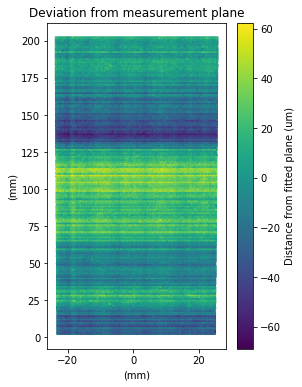

In [16]:
plt.figure(figsize=(4,6))
n = 10
plt.hexbin(sampleDisplaced.points[0][::n], 
           sampleDisplaced.points[1][::n], 
           sampleDisplaced.points[2][::n]*1000, 
           gridsize=300 )
plt.colorbar(label = 'Distance from fitted plane (um)')
plt.title('Deviation from measurement plane')
plt.xlabel('(mm)')
plt.ylabel('(mm)')

# Comments on the plot
It is apparent that there is an issue in the reproducibility with the plane.

I assume (poorly) that the same undulations are present when scanning the sample mirrors. For now, the error is just on the order of the allowable error. 

There is a z offset in the data, and that may provide problems, leading to a trajectory that is different on the mirror scans. Subsequently, the error might not be the same either. I will try to interpolate the data to provide the mean waviness, which I could then use to account for the undulation error on the mirror data.

# Investigating the flatness and corrections

### Binning unstructured data into 2D arrays
Warning: This takes a significant amount of time. It's not made very cleverly!

In [183]:
nx = 1000
ny = 4000
nn = 53


xs = np.linspace(sampleDisplaced.points[0].min(), sampleDisplaced.points[0].max(), nx)
ys = np.linspace(sampleDisplaced.points[1].min(), sampleDisplaced.points[1].max(), ny)
xx, yy = np.meshgrid(xs,ys)


points = np.array(([sampleDisplaced.points[0][::nn], sampleDisplaced.points[1][::nn]])).T

zzAlongY = griddata( points,
               sampleDisplaced.points[2][::nn],
               xi = (xx,yy),
               method = 'nearest')

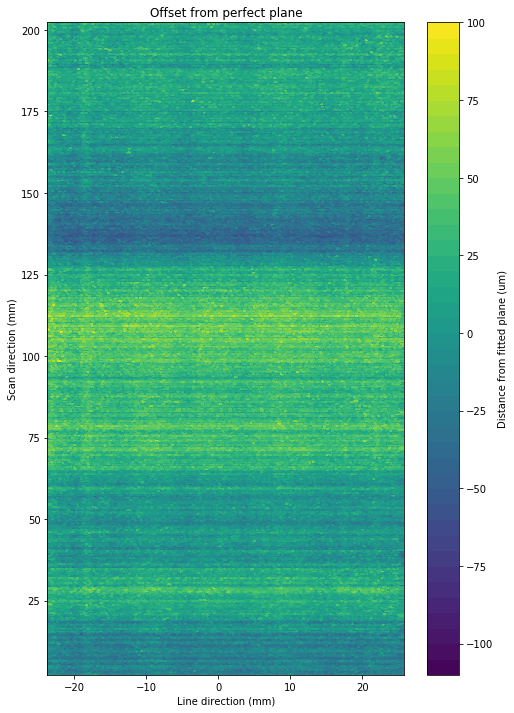

In [226]:
plt.figure(figsize=(8,12))

plt.contourf(xx, yy, zzAlongY*1000, levels=50)
plt.title('Offset from perfect plane')
plt.xlabel('Line direction (mm)')
plt.ylabel('Scan direction (mm)')
plt.colorbar(label = 'Distance from fitted plane (um)');

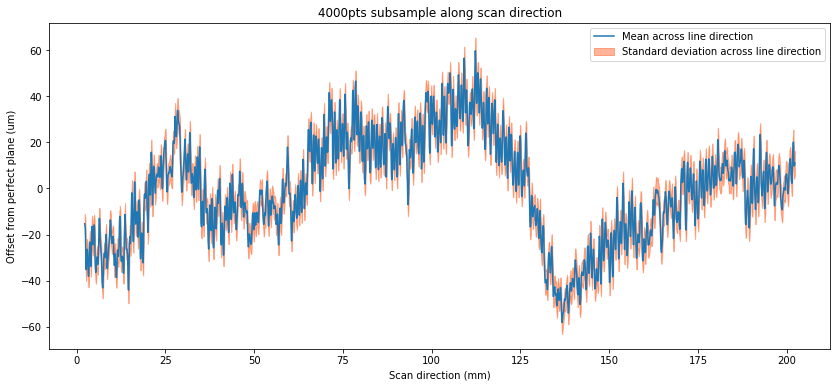

In [227]:
plt.figure(figsize = (14, 6))

mean = np.mean(zzAlongY, axis=1)*1000
std = np.std(zzAlongY, axis = 1)*500
plt.fill_between(yy[:, 0], (mean-std), (mean+std), alpha = 0.4, color='orangered', label = 'Standard deviation across line direction')
plt.plot(yy[:,0], mean, alpha = 1, label = 'Mean across line direction');
plt.xlabel('Scan direction (mm)')
plt.ylabel('Offset from perfect plane (um)')
plt.title('4000pts subsample along scan direction')
plt.legend();

In [230]:
errorAlongScan = np.tile(mean/1000, zzAlongY.shape[1]).reshape(1000, 4000).T
zzErrorCorrected = zzAlongY - errorAlongScan

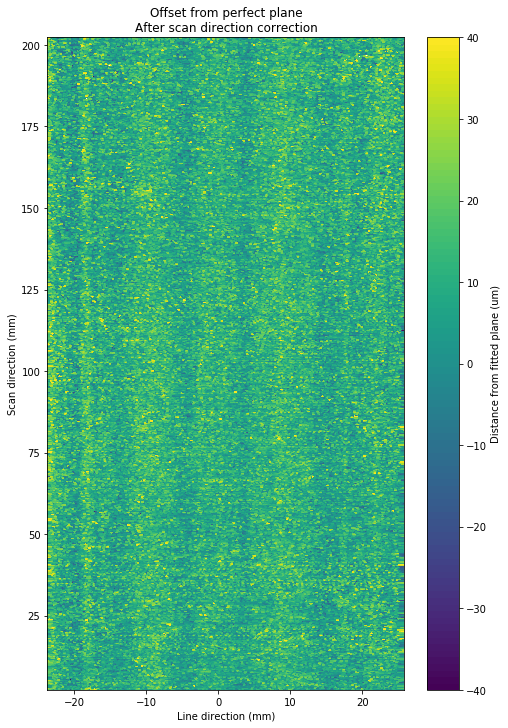

In [238]:
values = np.linspace(-40, 40, 100, endpoint=True)

plt.figure(figsize= (8,12))
plt.contourf(xx, yy, zzErrorCorrected*1000, values)
plt.title('Offset from perfect plane\nAfter scan direction correction')
plt.xlabel('Line direction (mm)')
plt.ylabel('Scan direction (mm)')
plt.colorbar(label = 'Distance from fitted plane (um)', extend='both', ticks = [-40, -30, -20, -10, 0, 10, 20, 30, 40]);

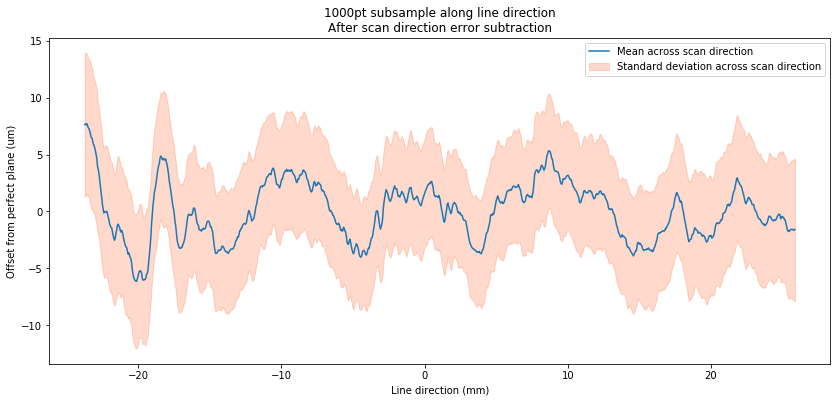

In [232]:
plt.figure(figsize = (14, 6))

mean = np.mean(zzErrorCorrected, axis=0)*1000
std = np.std(zzErrorCorrected, axis=0)*500
plt.plot(xx[0,:], mean, alpha = 1, label = 'Mean across scan direction');
plt.fill_between(xx[0,:], (mean-std), (mean+std), alpha = 0.2, color='orangered', label = 'Standard deviation across scan direction')
plt.xlabel('Line direction (mm)')
plt.ylabel('Offset from perfect plane (um)')
plt.title('1000pt subsample along line direction\nAfter scan direction error subtraction')
plt.legend();

## Export the error along scan line

In [245]:
outArr = np.array((yy[:,0], np.mean(zzAlongY, axis = 1)))

np.save("20190815_ErrorAlongScanLine.npy", outArr)

In [244]:
outArr.shape

(2, 4000)